# Revisão de código 

Olá! 

Meu nome é Suelen. Estou feliz em revisar seu projeto hoje!

Quando vejo um erro pela primeira vez, apenas aponto. Deixarei você encontrá-lo e corrigi-lo sozinho. Além disso, ao longo do texto, farei algumas observações sobre melhorias no código e também farei comentários sobre suas percepções sobre o assunto. Mas se você ainda não consegue lidar com essa tarefa, darei uma dica mais precisa na próxima iteração e também alguns exemplos práticos. Estarei aberto a feedbacks e discussões sobre o tema.

Você pode encontrar meus comentários em caixas verdes, amarelas ou vermelhas como estas:


<div class="alert alert-block alert-success">
<b>Comentário: </b> <a class="tocSkip"></a>

Sucesso. Tudo está correto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário: </b> <a class="tocSkip"></a>

Observações. Algumas recomendações.
</div>

<div class="alert alert-block alert-danger">

<b>Comentário: </b> <a class="tocSkip"></a>

O bloco requer algumas correções. O trabalho não pode ser aceito com os comentários vermelhos.
</div>

Você pode me responder usando isto:

<div class="alert alert-block alert-info">
<b>Resposta do aluno.  
    </b> <a class="tocSkip"></a>
</div>



<div class="alert alert-block alert-success">

<b>Comentário geral: </b> <a class="tocSkip"></a>

Parabéns pela conclusão do projeto, Lucas! 🎉

Estou muito feliz com o seu empenho e dedicação! O projeto foi muito bom e estou contente em dizer que está aprovado! 

Agora, vamos em frente para os próximos desafios!🚀
</div>

# Passo 1. Lendo dados e preparando pacotes

In [671]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

In [605]:
#carregando dados e retificando colunas
def rectifycolnames(df): # função para corrigir nomes de colunas
    new_col_names = []
    for col in df.columns:
        name_strip = col.strip()
        name_lower = name_strip.lower()
        name_no_space = name_lower.replace(' ', '_')
        new_col_names.append(name_no_space)
    return new_col_names
    
df = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')
df.columns = rectifycolnames(df)

df['eventtimestamp'] = pd.to_datetime(df['eventtimestamp'], unit = 's') # datetime em... segundos desde 1970 OoO
df[['deviceidhash', 'expid']] = df[['deviceidhash', 'expid']].astype('object')

# Passo 2. Preparo de dados pré análise

In [606]:
df['eventname'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [607]:
print('entradas duplicadas:', df.duplicated().sum())
df[df.duplicated(keep = False)].sort_values(['deviceidhash', 'eventtimestamp'])

entradas duplicadas: 413


,eventname,deviceidhash,eventtimestamp,expid
130557,MainScreenAppear,33176906322804559,2019-08-04 15:37:55,248
130558,MainScreenAppear,33176906322804559,2019-08-04 15:37:55,248
130994,OffersScreenAppear,33176906322804559,2019-08-04 15:49:23,248
130995,OffersScreenAppear,33176906322804559,2019-08-04 15:49:23,248
104106,CartScreenAppear,34565258828294726,2019-08-03 18:33:41,248
...,...,...,...,...
200170,PaymentScreenSuccessful,9160437016685643194,2019-08-06 15:13:36,247
200171,PaymentScreenSuccessful,9160437016685643194,2019-08-06 15:13:36,247
204829,PaymentScreenSuccessful,9187990861085277398,2019-08-06 17:01:28,247
204830,PaymentScreenSuccessful,9187990861085277398,2019-08-06 17:01:28,247


Aqui, os eventos "Payment Screen Successful" e "Offers Screen Appear" deveriam possuir mais informações sobre elas, como `payment_id` e `offer_id`.

Ao meu ver, se um usuário paga por um carrinho com 2 ou mais produtos, é possivel que o evento de pagamento seja duplicado. o mesmo pode ocorrer caso 2 ofertas sejam expostas ao cliente ao mesmo tempo (2 popups carregam, um atrás do outro), mas como o numero de duplicatas é pequeno em comparação ao numero de eventos no conjunto de dados, descartarei as duplicatas

In [608]:
df = df.drop_duplicates()

# Passo 3. Estudo dos dados brutos

## 3.1 Quantos eventos ficam nos registros?

In [609]:
print(df['eventname'].nunique(), 'eventos ficam nos registros')

5 eventos ficam nos registros


## 3.2 Quantos usuários ficam nos registros?

In [610]:
print(df['deviceidhash'].nunique(), 'usuários ficam nos registros')

7551 usuários ficam nos registros


## 3.3 Qual é o número médio de eventos por usuário?

In [611]:
events_per_user_avg = df.groupby('deviceidhash')['eventname'].count()
print(
    ('Eventos médios por usuários: {}\nMediana de eventos por usuários {}\n' + 
     'Moda de eventos por usuário: {}\nMáximo de eventos para um usuário: {}'
    ).format(
        events_per_user_avg.describe()[1].round(),
        events_per_user_avg.describe()[-3],
        events_per_user_avg.mode()[0],
        events_per_user_avg.describe()[-1])
     )

Eventos médios por usuários: 32.0
Mediana de eventos por usuários 20.0
Moda de eventos por usuário: 5
Máximo de eventos para um usuário: 2307.0


## 3.4 Qual é o período de tempo que os dados cobrem?

### 3.4.1 Dados brutos

In [612]:
time_start = df['eventtimestamp'].min()
time_end = df['eventtimestamp'].max()
time_delta = time_end - time_start
print('os dados brutos começaram dia {} e terminaram dia {} do ano 2019\nDuração = {} dias'.format(
    time_start.date().strftime("%d/%m"),
    time_end.date().strftime("%d/%m"),
    time_delta.days,
))

os dados brutos começaram dia 25/07 e terminaram dia 07/08 do ano 2019
Duração = 13 dias


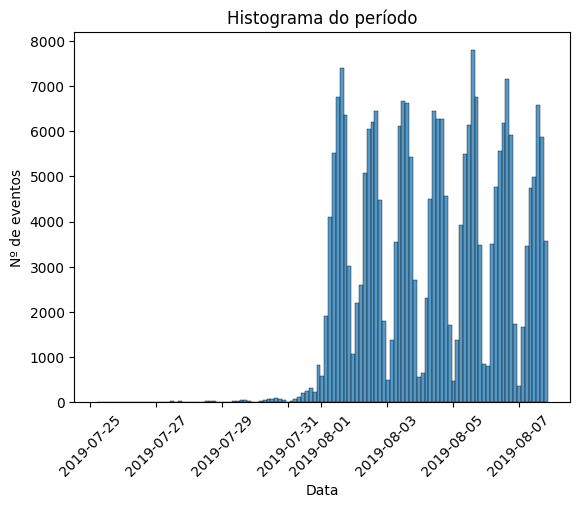

In [613]:
sns.histplot(df['eventtimestamp'])
plt.xticks(rotation=45)
plt.title('Histograma do período')
plt.xlabel('Data')
plt.ylabel('Nº de eventos')
plt.show()

Houveram poucos eventos na ultima semana de julho, e muitos em agosto.

### 3.4.2 Analisando periodos de coletas de dados

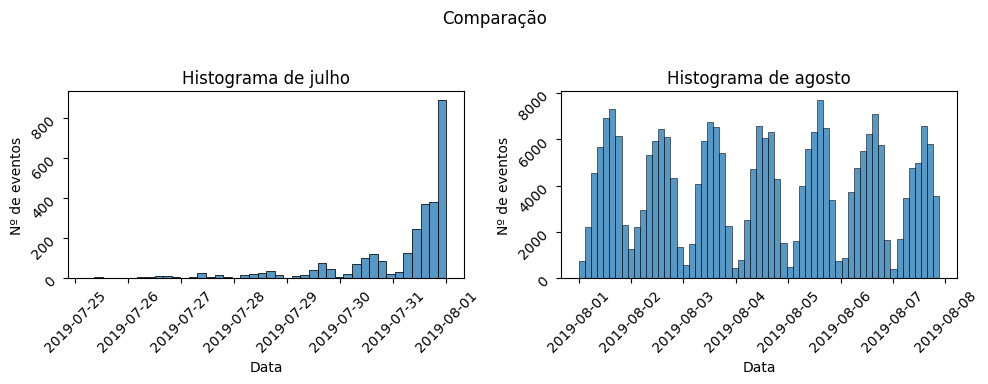

atenção à magnitude dos valores de julho.


In [614]:
df_july = df[df['eventtimestamp'].dt.month == 7]
df_august = df[df['eventtimestamp'].dt.month == 8]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df_july['eventtimestamp'], ax = ax1)
ax1.tick_params(rotation=45)
ax1.set_title('Histograma de julho')
ax1.set_xlabel('Data')
ax1.set_ylabel('Nº de eventos')

sns.histplot(df_august['eventtimestamp'], ax = ax2)
ax2.tick_params(rotation=45)
ax2.set_title('Histograma de agosto')
ax2.set_xlabel('Data')
ax2.set_ylabel('Nº de eventos')

fig.suptitle("Comparação")

# Adjust layout to prevent labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle
plt.show()
print('atenção à magnitude dos valores de julho.')

<div class="alert alert-block alert-success">
<b>Comentário: </b> <a class="tocSkip"></a>

- [x] Estatísticas foram calculadas corretamente
- [x] A quantidade de ocorrências por evento foi analisada corretamente
- [x] Foram adicionadas suas observações sobre os resultados acima
    
</div>

Visto a discrepância na coleta de dados do experimento, irei trabalhar somente com os dados de agosto

In [615]:
new_df = df[df['eventtimestamp'].dt.month >= 8].copy()

### 3.4.3 Descartando dados irrelevantes/prejudiciais à análise

In [616]:
time_start = new_df['eventtimestamp'].min()
time_end = new_df['eventtimestamp'].max()
time_delta = time_end - time_start
print('os dados relevantes começaram dia {} e terminaram dia {} do ano 2019\nDuração = {} dias'.format(
    time_start.date().strftime("%d/%m"),
    time_end.date().strftime("%d/%m"),
    time_delta.days,
))

os dados relevantes começaram dia 01/08 e terminaram dia 07/08 do ano 2019
Duração = 6 dias


## 3.5 Há a perda de muitos eventos e usuários ao excluir os dados mais antigos?

In [617]:
deleted_rows = df.shape[0] - new_df.shape[0]
print(f'apenas {deleted_rows} entradas foram perdidas\n{round(((deleted_rows/df.shape[0])*100), 2)}% de diferença')

apenas 2826 entradas foram perdidas
1.16% de diferença


## 3.6 verificando a integridade dos grupos experimentais

In [618]:
exp_id = df['expid'].value_counts()
exp_before = {
    "246":exp_id[246],
    "247":exp_id[247],
    "248":exp_id[248]
}
exp_before['246n'] = df.groupby('expid')['deviceidhash'].nunique()[246] 
exp_before['247n'] = df.groupby('expid')['deviceidhash'].nunique()[247] 
exp_before['248n'] = df.groupby('expid')['deviceidhash'].nunique()[248] 

exp_id = new_df['expid'].value_counts()
exp_after = {
    "246":exp_id[246],
    "247":exp_id[247],
    "248":exp_id[248]
}
exp_after['246n'] = new_df.groupby('expid')['deviceidhash'].nunique()[246] 
exp_after['247n'] = new_df.groupby('expid')['deviceidhash'].nunique()[247] 
exp_after['248n'] = new_df.groupby('expid')['deviceidhash'].nunique()[248]

print(
    ('Grupos antes do descarte:\nRegistros 246: {}\nRegistros 247: {}\nRegistros 248: {}\n' +
     'Usuários antes do descarte:\n246: {}\n247: {}\n248: {}\n\n' +
      'Grupos após o descarte:\nRegistros 246: {}\nRegistros 247: {}\nRegistros 248: {}\n' +
     'Usuários após do descarte:\n246: {}\n247: {}\n248: {}'
    ).format(exp_before['246'],
             exp_before['247'],
             exp_before['248'],
             exp_before['246n'],
             exp_before['247n'],
             exp_before['248n'],
             exp_after['246'],
             exp_after['247'],
             exp_after['248'],
             exp_after['246n'],
             exp_after['247n'],
             exp_after['248n'],
            )
)

Grupos antes do descarte:
Registros 246: 80181
Registros 247: 77950
Registros 248: 85582
Usuários antes do descarte:
246: 2489
247: 2520
248: 2542

Grupos após o descarte:
Registros 246: 79302
Registros 247: 77022
Registros 248: 84563
Usuários após do descarte:
246: 2484
247: 2513
248: 2537


In [619]:
exp_diff = {key: exp_before[key] - exp_after.get(key, 0)
                       for key in exp_before.keys()}
exp_diff
print('Diferenças:\n246: {}%\n247: {}%\n248: {}%'
     .format(
         round(((exp_diff['246']/exp_before['246'])*100), 2),
         round(((exp_diff['247']/exp_before['247'])*100), 2),
         round(((exp_diff['248']/exp_before['248'])*100), 2),
     ))

Diferenças:
246: 1.1%
247: 1.19%
248: 1.19%


Houve pouca variação nos grupos experimentais.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
  
As estatísticas dos usuários foram analisadas. 



</div>

# Passo 4. Estudo do funil de eventos

# 4.1 Frequências de eventos


### 4.1.1 Calculando frequência de cada evento

In [620]:
new_df['day'] = new_df['eventtimestamp'].dt.day
event_day = new_df.groupby('day')['eventname'].value_counts()
event_day = event_day.unstack(level=1)
event_freq_mean = event_day.mean(axis = 0).sort_values(ascending = False).rename('daily_mean')

### 4.1.2 Classificando

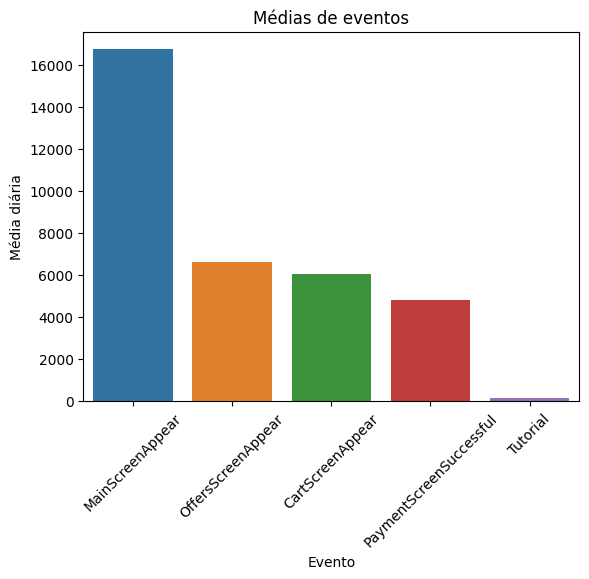

In [621]:
sns.barplot(x = event_freq_mean.index, y = event_freq_mean)
plt.xticks(rotation=45)
plt.title('Médias de eventos')
plt.xlabel('Evento')
plt.ylabel('Média diária')
plt.show()

# 4.2 Funil de eventos

### 4.2.1 Usuários que executaram cada evento

In [622]:
event_counts = event_day.sum(axis = 0).sort_values(ascending = False).rename('total_entries')
users_events = new_df.groupby('eventname')['deviceidhash'].nunique().rename('total_users')
events = pd.DataFrame(event_counts)
events = events.join(users_events)

### 4.2.2 Classificando

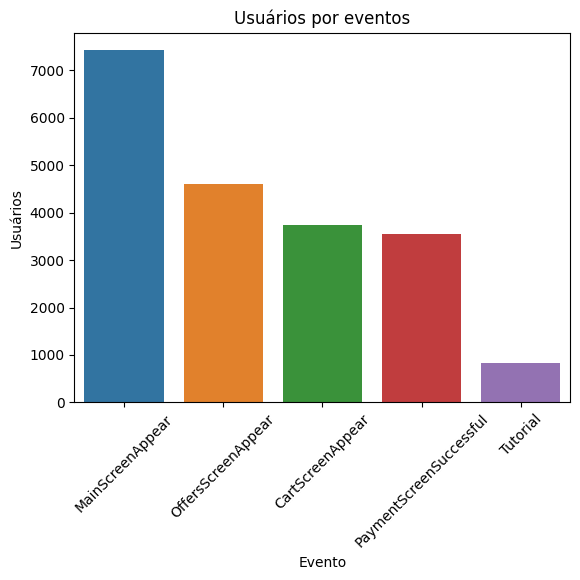

In [623]:
sns.barplot(x = events.index, y = events['total_users'])
plt.xticks(rotation=45)
plt.title('Usuários por eventos')
plt.xlabel('Evento')
plt.ylabel('Usuários')
plt.show()

### 4.2.3 Executaram pelo menos uma vez

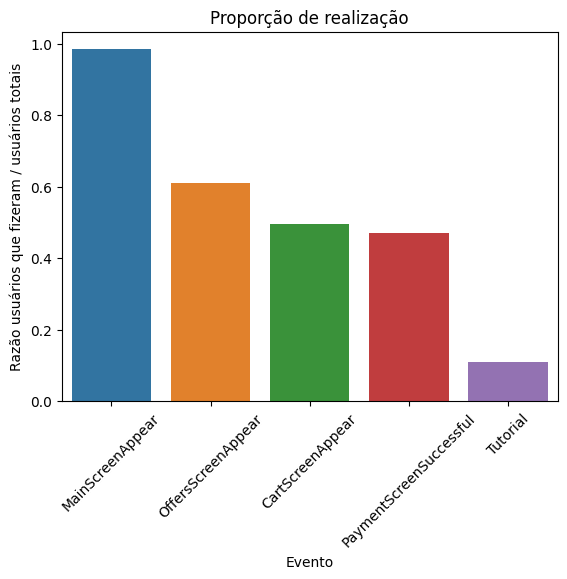

In [624]:
events['execution_ratio'] = events['total_users'] / new_df['deviceidhash'].nunique()

sns.barplot(x = events.index, y = events['execution_ratio'])
plt.xticks(rotation=45)
plt.title('Proporção de realização')
plt.xlabel('Evento')
plt.ylabel('Razão usuários que fizeram / usuários totais')
plt.show()


# 4.3 Comentários sobre ordens e sequências das ações

Impressões iniciais:

A ordem em que as ações devem ocorrer é:
1. Tutorial (usuário visualiza o tutorial do app)
2. Main Screen Appear (usuário vai para a tela principal)
3. Offers Screen Appear (usuário visualiza produto)
4. Cart Screen Appear (usuário entra no carrinho)
5. Payment Sreen Successful (usuário faz o pagamento)

Sobre a sequência das ações:
1. um usuário pode não ver o tutorial, ou por pular ou por já ter o visto antes
2. um usuário provavelmente deve obrigatoriamente passar pela tela principal antes de fazer seus pedidos
3. um usuário não necessariamente deve acessar a página de um produto para prosseguir (pode ter o adicionado em outra sessão)
4. um usuário provavelmente deve obrigatoriamente visualizar o carrinho antes de realizar uma compra

In [625]:
access_tut = df[df['eventname'] == "Tutorial"]['deviceidhash'].nunique()
access_tut_mult = df[df['eventname'] == "Tutorial"]['deviceidhash'].value_counts() > 1
print(f'Usuários que completaram o tutorial: {access_tut}\nUsuários que o acessaram novamente: {access_tut_mult.sum()}')

Usuários que completaram o tutorial: 847
Usuários que o acessaram novamente: 89


847 usuários acessaram o tutorial, isso é pouco mais de 10% dos usuários nos dados, o que significa que os outros 90% ou pularam, ou o realizaram antes da coleta de dados
89 usuários acessaram o tutorial mais de uma vez! talvez estes usuários estejam enfrentando dificuldades para utilizar a plataforma

# 4.4 Análise de funis

### 4.4.1 Criando funis de etapas

#### 4.4.1.1 tutorial > principal > oferta > carrinho > compra

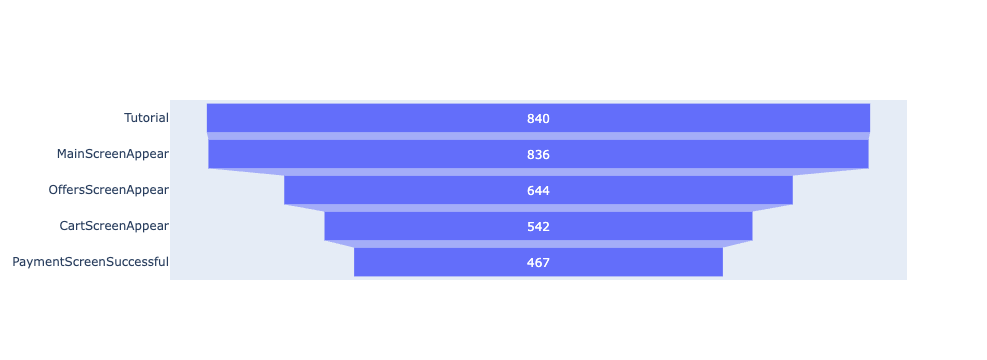

In [626]:
funnel_users = new_df[new_df['eventname'] == 'Tutorial']['deviceidhash'].unique()
funnel_df = new_df[new_df['deviceidhash'].isin(funnel_users)].groupby('eventname')['deviceidhash'].nunique()
funnel_df = funnel_df.reindex(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])
full_path = funnel_df[-1]
fig = go.Figure(go.Funnel(
    y = funnel_df.index,
    x = funnel_df
    ))
fig.show()

55,6% destes usuários completam o pedido, vamos comparar com os outros funis

Taxa de retenção tutorial > principal é 99,5%

#### 4.4.1.1 principal > oferta > carrinho > compra

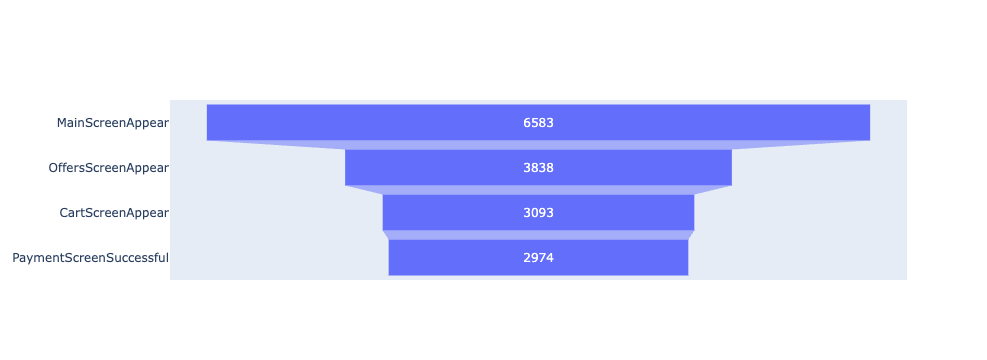

In [627]:
funnel_users_2 = new_df[new_df['eventname'] == 'MainScreenAppear']['deviceidhash'].unique()
funnel_df = new_df[
    np.logical_and(
        ~new_df['deviceidhash'].isin(funnel_users), 
        new_df['deviceidhash'].isin(funnel_users_2)
        )
    ].groupby('eventname')['deviceidhash'].nunique()
funnel_df = funnel_df.reindex(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])
fig = go.Figure(go.Funnel(
    y = funnel_df.index,
    x = funnel_df
    ))
fig.show()

Somente 45% destes completam o pedido, o funil se estreita quando usuários não completam o tutorial, principalmente após o acesso à página principal

#### 4.4.1.2 principal > carrinho > compra

In [628]:
new_df[new_df['deviceidhash'].isin(
    np.setdiff1d(
        new_df[new_df['eventname'] == 'MainScreenAppear']['deviceidhash'].unique(),
        new_df[new_df['eventname'] == 'OffersScreenAppear']['deviceidhash'].unique()
    )
)
    ]['eventname'].value_counts()

MainScreenAppear           43180
Tutorial                     263
CartScreenAppear             119
PaymentScreenSuccessful       16
Name: eventname, dtype: int64

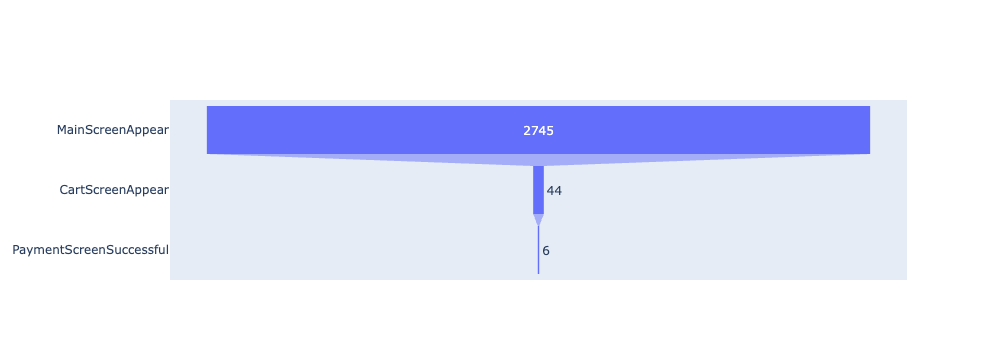

In [629]:
funnel_users_3 = np.setdiff1d(
    new_df[new_df['eventname'] == 'MainScreenAppear']['deviceidhash'].unique(),
    new_df[new_df['eventname'] == 'OffersScreenAppear']['deviceidhash'].unique()
        )
funnel_df = new_df[
    np.logical_and(
        ~new_df['deviceidhash'].isin(funnel_users),
        new_df['deviceidhash'].isin(funnel_users_3)
        )
    ].groupby('eventname')['deviceidhash'].nunique()
funnel_df = funnel_df.reindex(['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])
fig = go.Figure(go.Funnel(
    y = funnel_df.index,
    x = funnel_df
    ))
fig.show()

In [630]:
funnel_df['MainScreenAppear'] / new_df['deviceidhash'].nunique()

0.36434828776214495

Quase nenhum usuário que não fez tutorial, nem viu oferta completou um pedido.

essa parcela de usuários corresponde a 36% dos usuários do app!

# 4.5 Em qual fase você perde mais usuários?

A maioria dos usuários são perdidos entre o acesso da página principal e o acesso da página da oferta, ainda mais são perdidos no acesso direto da pagina principal para o carrinho.

# 4.6 Parcela de usuários que faz o caminho inteiro, desde o primeiro evento até o pagamento

In [631]:
ratio = round((full_path / new_df['deviceidhash'].nunique())*100, 2)
print(f'Apenas {ratio}% dos usuários fizeram o caminho inteiro')

Apenas 6.2% dos usuários fizeram o caminho inteiro


# Passo 5. Estudos de resultados de experimento

# 5.1 Tamanho dos grupos

In [632]:
group_A_1 = new_df[new_df['expid'] == 246].copy()
group_A_2 = new_df[new_df['expid'] == 247].copy()
group_B = new_df[new_df['expid'] == 248].copy()
print(f"Grupo 246: {group_A_1['deviceidhash'].nunique()} usuários\nGrupo 247: {group_A_2['deviceidhash'].nunique()} usuários\nGrupo 248: {group_B['deviceidhash'].nunique()} usuários")

Grupo 246: 2484 usuários
Grupo 247: 2513 usuários
Grupo 248: 2537 usuários


# 5.2 Verificando diferença estatisticamente significativa entre as amostragens 246 e 247 (controles).


In [633]:
Entries_A_1 = group_A_1.groupby(
    'deviceidhash',
     as_index=False
    ).agg(
        {
            'eventtimestamp' : pd.Series.nunique,
            'eventname': lambda x: (x == 'PaymentScreenSuccessful').sum()
        }
            )

Entries_A_1.columns = ['deviceidhash', 'sessionts', 'checkouts']
Entries_A_1['checkout_ratio'] = Entries_A_1['checkouts'] / Entries_A_1['sessionts']

Entries_A_2 = group_A_2.groupby(
    'deviceidhash',
     as_index=False
    ).agg(
        {
            'eventtimestamp' : pd.Series.nunique,
            'eventname': lambda x: (x == 'PaymentScreenSuccessful').sum()
        }
            )

Entries_A_2.columns = ['deviceidhash', 'sessionts', 'checkouts']
Entries_A_2['checkout_ratio'] = Entries_A_2['checkouts'] / Entries_A_2['sessionts']

Dataframes com numeros de sessões, checkouts e proporção para cada usuário do grupo

In [634]:
alpha = 0.05
print('Teste A/A, numero de sessões se diferem?')
p = stats.mannwhitneyu(Entries_A_1['sessionts'].unique(), Entries_A_2['sessionts'].unique())[1]
if p > alpha:
    print('Não')
else:
    print('Sim')
    
print('Teste A/A, numero de checkout se diferem?')
p = stats.mannwhitneyu(Entries_A_1['checkouts'].unique(), Entries_A_2['checkouts'].unique())[1]
if p > alpha:
    print('Não')
else:
    print('Sim')
    
print('Teste A/A, razão de checkout se difere??')
p = stats.mannwhitneyu(Entries_A_1['checkout_ratio'].unique(), Entries_A_2['checkout_ratio'].unique())[1]
if p > alpha:
    print('Não')
else:
    print('Sim')

Teste A/A, numero de sessões se diferem?
Não
Teste A/A, numero de checkout se diferem?
Não
Teste A/A, razão de checkout se difere??
Não


Não há diferença significativa nas principais ações dos usuários dos grupos de controle

# 5.3 Selecione o evento mais popular. Em cada um dos grupos de controle, encontre o número de usuários que realizaram essa ação. Encontre a proporção deles. Verifique se a diferença entre os grupos é estatisticamente significativa. Repita o procedimento para todos os outros eventos (economizará tempo se você criar uma função especial para este teste). Você pode confirmar se os grupos foram divididos corretamente?


In [682]:
def ratioevents(group, event):
    Entries = group.groupby(
    'deviceidhash',
     as_index=False
    ).agg(
        {
            'eventtimestamp' : pd.Series.nunique,
            'eventname': lambda x: (x == event).sum()
        }
            )
    return Entries
    
group_A = new_df[(new_df['expid'] == 246) | (new_df['expid'] == 247)].copy()
ratios_A = pd.DataFrame()
ratios_A_1 = pd.DataFrame()
ratios_A_2 = pd.DataFrame()
ratios_B = pd.DataFrame()

for event in group_A['eventname'].unique():
    ratios_A['sessions'] = ratioevents(group_A, event)['eventtimestamp']
    ratios_A[event] = ratioevents(group_A, event)['eventname']
    ratios_A[event] = ratios_A[event] / ratios_A['sessions']

for event in group_A['eventname'].unique():
    ratios_A_1['sessions'] = ratioevents(group_A_1, event)['eventtimestamp']
    ratios_A_1[event] = ratioevents(group_A_1, event)['eventname']
    ratios_A_1[event] = ratios_A_1[event] / ratios_A_1['sessions']
    
for event in group_A['eventname'].unique():
    ratios_A_2['sessions'] = ratioevents(group_A_2, event)['eventtimestamp']
    ratios_A_2[event] = ratioevents(group_A_2, event)['eventname']
    ratios_A_2[event] = ratios_A_2[event] / ratios_A_2['sessions']
    
for event in group_B['eventname'].unique():
    ratios_B['sessions'] = ratioevents(group_B, event)['eventtimestamp']
    ratios_B[event] = ratioevents(group_B, event)['eventname']
    ratios_B[event] = ratios_B[event] / ratios_B['sessions']

In [683]:
for event in group_A['eventname'].unique():
    p = stats.mannwhitneyu(ratios_A_1[event].unique(), ratios_A_2[event].unique())[1]
    print(f'valor p do evento {event}: {p}')

valor p do evento Tutorial: 0.16734423897337414
valor p do evento MainScreenAppear: 0.3416175574247382
valor p do evento OffersScreenAppear: 0.2041827525263593
valor p do evento PaymentScreenSuccessful: 0.3903577634459292
valor p do evento CartScreenAppear: 0.12864245944116026


# 5.4 Faça a mesma coisa para o grupo com fontes alteradas. Compare os resultados com os de cada um dos grupos de controle para cada evento isoladamente. Compare os resultados com os resultados combinados para os grupos de controle. Quais conclusões você pode tirar do experimento?


In [684]:
for event in group_A['eventname'].unique():
    p = stats.mannwhitneyu(ratios_A[event].unique(), ratios_B[event].unique())[1]
    print(f'valor p do evento {event}: {p}')

valor p do evento Tutorial: 0.2312994646934402
valor p do evento MainScreenAppear: 0.4515880748484613
valor p do evento OffersScreenAppear: 0.9883585101065955
valor p do evento PaymentScreenSuccessful: 0.3997569668575963
valor p do evento CartScreenAppear: 0.7731282867198342


<div class="alert alert-block alert-success">
<b> Comentário: </b> <a class="tocSkip"></a>
    
Testes realizados corretamente!

# 5.5 Qual nível de significância você definiu para testar as hipóteses estatísticas mencionadas acima? Calcule quantos testes de hipóteses estatísticas você realizou. Com um nível de significância estatística de 0,1, um de cada 10 resultados pode ser falso. Qual deveria ser o nível de significância? Se você quiser alterá-lo, execute as etapas anteriores novamente e verifique suas conclusões.


O nivel de significancia escolhido foi 0.05, e como nenhum resultado esteve a baixo deste nivel, concluo que a mudança da fonte não teve impacto real na proporção de usuários que avançam para outras fases do app.

<div class="alert alert-block alert-success">
<b> Comentário: </b> <a class="tocSkip"></a>
    
Boa conclusão! Completa e baseada em evidências
